In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Base de dados

In [3]:
path = "/content/gdrive/My Drive/v1/"

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import time
from math import pi
from scipy import signal
import pandas as pd

In [4]:
thetav = np.loadtxt(path + 'Datasets/thetav.csv',delimiter=',')[:1000]
Vec = np.loadtxt(path + 'Datasets/datasets/Vecv-1000.csv',delimiter = ',')

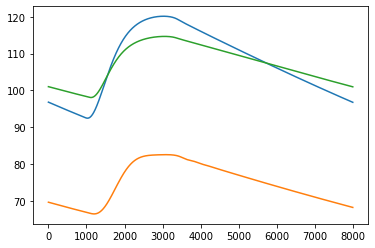

In [6]:
plt.plot(Vec[:3].T)

# Estimação

In [8]:
import tensorflow as tf
from tensorflow.keras import Sequential, layers
import pandas as pd
import numpy as np
from scipy import stats
from tensorflow import keras

from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [9]:
sc = MinMaxScaler()
X_n = sc.fit_transform(Vec)
sc2 = MinMaxScaler()
y_n = sc2.fit_transform(thetav)

In [10]:
X_n = X_n.reshape(-1,8000,1)
select=[1]
#X_n = signal.resample(X_n,360,axis=0)

In [11]:
train_size = 0.7
lng = len(X_n)
X_treinamento = X_n[:round(lng*0.6)]
y_treinamento = y_n[:round(lng*0.6)]
X_valid = X_n[round(lng*0.6):round(lng*0.85)]
y_valid = y_n[round(lng*0.6):round(lng*0.85)]
X_test = X_n[round(lng*0.85):]
y_test = y_n[round(lng*0.85):]
X_treinamento, X_valid, X_test = X_treinamento.reshape(-1,X_treinamento.shape[1],1), X_valid.reshape(-1,X_treinamento.shape[1],1),  X_test.reshape(-1,X_treinamento.shape[1],1)

In [12]:
X_treinamento.shape,y_treinamento.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((600, 8000, 1),
 (600, 10),
 (250, 8000, 1),
 (250, 10),
 (150, 8000, 1),
 (150, 10))

## CNN-LSTM

In [13]:
input_layer1 = keras.layers.Input(X_treinamento.shape[1:])

conv1 = keras.layers.Conv1D(filters=32, kernel_size=8,strides=400)(input_layer1)
conv1 = keras.layers.MaxPooling1D()(conv1)
conv1 = keras.layers.Activation(activation='relu')(conv1)
conv2 = keras.layers.Conv1D(filters=64, kernel_size=3)(conv1)
conv2 = keras.layers.MaxPooling1D()(conv2)
conv2 = keras.layers.Activation(activation='relu')(conv2)
flt = keras.layers.Flatten()(conv2)
lstm = keras.layers.LSTM(20)(input_layer1)
flt2 = keras.layers.Flatten()(lstm)
concat = keras.layers.concatenate([flt,flt2])

dense2 = keras.layers.Dense(50,activation='relu')(concat)
dense2 = keras.layers.Dense(50,activation='relu')(dense2)

out = keras.layers.Dense(10, activation='linear')(dense2)


model = keras.models.Model(inputs=input_layer1, outputs=out)


model.compile(optimizer=tf.keras.optimizers.Adam(),  # Optimizer
              loss='mse')

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=20,
                                                      min_lr=0.0001)
file_path = path + 'LSTM_TDE_MSE.hdf5'
model_checkpoint = keras.callbacks.ModelCheckpoint(filepath=file_path, monitor='loss', save_best_only=True)
callbacks = [reduce_lr ,model_checkpoint]
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8000, 1)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 20, 32)       288         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 10, 32)       0           conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 10, 32)       0           max_pooling1d[0][0]              
______________________________________________________________________________________________

# Fit model on training data
Epoch 1/300
10/10 [==============================] - 8s 841ms/step - loss: 0.2742 - val_loss: 0.1952 - lr: 0.0010
Epoch 2/300
10/10 [==============================] - 7s 701ms/step - loss: 0.1461 - val_loss: 0.1186 - lr: 0.0010
Epoch 3/300
10/10 [==============================] - 7s 682ms/step - loss: 0.1050 - val_loss: 0.0941 - lr: 0.0010
Epoch 4/300
10/10 [==============================] - 7s 677ms/step - loss: 0.0919 - val_loss: 0.0911 - lr: 0.0010
Epoch 5/300
10/10 [==============================] - 7s 676ms/step - loss: 0.0897 - val_loss: 0.0897 - lr: 0.0010
Epoch 6/300
10/10 [==============================] - 7s 676ms/step - loss: 0.0876 - val_loss: 0.0876 - lr: 0.0010
Epoch 7/300
10/10 [==============================] - 7s 684ms/step - loss: 0.0856 - val_loss: 0.0860 - lr: 0.0010
Epoch 8/300
10/10 [==============================] - 7s 681ms/step - loss: 0.0839 - val_loss: 0.0841 - lr: 0.0010
Epoch 9/300
10/10 [==============================] - 7s 678

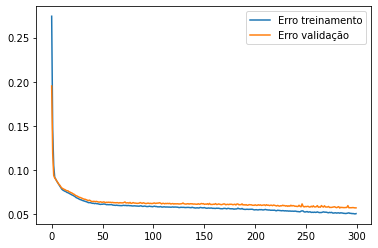

In [14]:
print('# Fit model on training data')
history = model.fit(X_treinamento, (y_treinamento),
                    batch_size=64,
                    epochs=300,
                    validation_data=(X_valid, (y_valid)),
                    callbacks=callbacks)
                    

plt.figure()
plt.plot(history.history['loss'], label='Erro treinamento')
plt.plot(history.history['val_loss'], label='Erro validação')
plt.legend()
plt.show()

In [17]:
LSTM_model = keras.models.load_model(path + 'LSTM_TDE_MSE.hdf5')
y_pred_LSTM = LSTM_model.predict(X_test)

## LSTM - Resultados

In [18]:
MSE = ((y_test - y_pred_LSTM)**2).mean(axis=0)
print(MSE)

[0.01342847 0.07229094 0.08092454 0.05868692 0.05946251 0.01511583
 0.08595131 0.07965745 0.0106672  0.07754559]


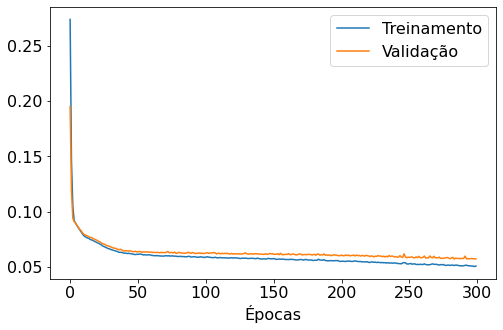

In [19]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize = (8,5))
plt.plot(history.history['loss'], label='Treinamento')
plt.plot(history.history['val_loss'], label='Validação')
plt.xlabel('Épocas')
plt.legend()
plt.savefig('Loss.pdf',bbox_inches = 'tight', dpi=300)
plt.savefig('loss.png',bbox_inches = 'tight', dpi=300)

In [20]:
y_test_o, y_pred_LSTM_o = sc2.inverse_transform(y_test), sc2.inverse_transform(y_pred_LSTM)

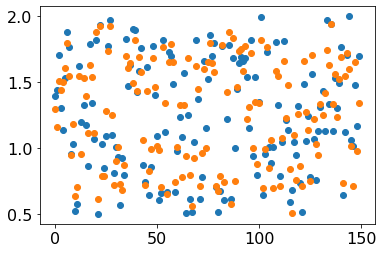

In [21]:
n_amostras = np.arange(len(y_test))
plt.plot(n_amostras,y_test_o[:,0],'o',n_amostras,y_pred_LSTM_o[:,0],'o')